In [19]:
import math
import geopy
from sgp4.api import Satrec
import datetime
from pyproj import Transformer
from astropy.time import Time
from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential
from astropy import units as u
import imageio
from pyproj import Transformer
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, GCRS, ITRS
from astropy import units as u, time
from astropy.time import Time
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Calculate the Satellite's FoV: Implement a function to calculate the FoV based on the satellite's altitude, latitude, and longitude. This involves geometric calculations to map the satellite's position to a surface area on Earth.
# Filter CERES Data Based on FoV: Modify your plotting functions to only plot the data that falls within the satellite's FoV. This will likely involve filtering the latitude and longitude arrays based on the calculated FoV.
# Time-Dependent Processing: Implement a system that updates the satellite's position and FoV at regular intervals (e.g., every 5 minutes), and then plots the corresponding visible CERES data.

In [3]:

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

# Example usage with dummy coordinates
dummy_latitude = 0    # degrees
dummy_longitude = 0   # degrees
dummy_altitude = 15000  # kilometers

fov_boundaries = calculate_satellite_fov(dummy_altitude)
fov_boundaries

(-90, 90, -180, 180)

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

In [5]:
# Example satellite position
satellite_latitude = 10  # degrees
satellite_longitude = 20 # degrees
satellite_altitude = 400 # kilometers

# Calculate FoV
min_lat, max_lat, min_lon, max_lon = calculate_satellite_fov(satellite_latitude, satellite_longitude, satellite_altitude)

In [6]:

def plot_fov_radiation(variable_name, time_index, radiation_data, lat, lon, min_lat, max_lat, min_lon, max_lon, output_folder):
    # Filter the latitude and longitude arrays based on the FoV boundaries
    lat_filter = (lat >= min_lat) & (lat <= max_lat)
    lon_filter = (lon >= min_lon) & (lon <= max_lon)

    # Apply the filter to the radiation data
    radiation_data_fov = radiation_data[time_index, lat_filter, :][:, lon_filter]
    lat_fov = lat[lat_filter]
    lon_fov = lon[lon_filter]

    # Meshgrid for the filtered latitude and longitude
    lon2d, lat2d = np.meshgrid(lon_fov, lat_fov)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Similar color scale limits and colormap as in your original function
    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    radiation_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(radiation_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')

    # Save the figure
    plt.show()
    # os.makedirs(output_folder, exist_ok=True)
    # plt.savefig(os.path.join(output_folder, f'{variable_name}_FoV_{time_index//12 + 2000}_{time_index%12 + 1:02d}.png'), dpi=300)
    # plt.close(fig)

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    # Approximate the FoV in degrees (latitude and longitude)
    # This is a simplification and works best for lower altitudes
    max_lat_long_range = math.degrees(horizon_distance_km / earth_radius_km)

    # Calculate the boundary coordinates
    min_latitude = max(-90, latitude - max_lat_long_range)
    max_latitude = min(90, latitude + max_lat_long_range)
    min_longitude = max(-180, longitude - max_lat_long_range)
    max_longitude = min(180, longitude + max_lat_long_range)

    return min_latitude, max_latitude, min_longitude, max_longitude

In [7]:
from datetime import datetime, timedelta
import numpy as np

# Convert MJD to regular datetime
def mjd_to_datetime(mjd):
    # MJD to JD
    jd = mjd + 2400000.5
    # JD to datetime
    jd_reference = datetime(1858, 11, 17)
    return jd_reference + timedelta(days=jd)

# Reference date from CERES dataset
#TODO: make this automatically extract from the dataset
ceres_ref_date = datetime(2000, 3, 1)

# Convert satellite MJD to CERES time format
# def satellite_time_to_ceres_time(mjd):
#     satellite_datetime = mjd_to_datetime(mjd)
#     return (satellite_datetime - ceres_ref_date).days

def mjd_to_ceres_time(mjd, ceres_ref_date=datetime(2000, 3, 1)):
    # Convert MJD to datetime
    satellite_datetime = mjd_to_datetime(mjd)
    
    # Convert to fraction of day since the reference date
    delta = satellite_datetime - ceres_ref_date
    return delta.days + delta.seconds / (24 * 60 * 60)

In [33]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geopy.distance import great_circle
import netCDF4 as nc

def is_within_fov(sat_lat, sat_lon, horizon_dist, point_lat, point_lon):
    """
    Check if a point is within the satellite's field of view.
    """
    distance = great_circle((sat_lat, sat_lon), (point_lat, point_lon)).kilometers
    return distance <= horizon_dist

def is_within_fov_vectorized(sat_lat, sat_lon, horizon_dist, point_lats, point_lons):
    """
    Vectorized check if points are within the satellite's field of view.
    """
    R = 6371.0  # Radius of the Earth in kilometers

    sat_lat_rad = np.radians(sat_lat)
    sat_lon_rad = np.radians(sat_lon)
    point_lats_rad = np.radians(point_lats)
    point_lons_rad = np.radians(point_lons)

    dlon = point_lons_rad - sat_lon_rad
    dlat = point_lats_rad - sat_lat_rad

    a = np.sin(dlat / 2)**2 + np.cos(sat_lat_rad) * np.cos(point_lats_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance <= horizon_dist


def plot_fov_radiation_scatter(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, horizon_dist, output_path):
    # Initialize an empty list to hold the radiation values within the FoV
    lat_points, lon_points, radiation_points = [], [], []

    # Iterate over the grid and collect data points within the FoV
    for i in range(len(lat)):
        for j in range(len(lon)):
            if is_within_fov(sat_lat, sat_lon, horizon_dist, lat[i], lon[j]):
                lat_points.append(lat[i])
                lon_points.append(lon[j])
                radiation_points.append(radiation_data[time_index, i, j])

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    scatter_plot = ax.scatter(lon_points, lat_points, c=radiation_points, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(scatter_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    ax.gridlines(draw_labels=True)
    plt.title(f'{variable_name} {time_index//12 + 2000}-{time_index%12 + 1:02d}')
    plt.savefig(output_path)
    plt.close(fig)
    plt.show()

# Helper function to convert CERES time to a readable date format
def convert_ceres_time_to_date(ceres_time):
    reference_date = datetime(2000, 3, 1)
    current_date = reference_date + timedelta(days=int(ceres_time))
    return current_date.strftime('%Y-%m-%d')

def plot_fov_radiation_mesh(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, horizon_dist, output_path, ceres_times):
    # Create a mask for the FoV
    fov_mask = np.zeros((len(lat), len(lon)), dtype=bool)

    # Update the mask based on the FoV
    for i in range(len(lat)):
        for j in range(len(lon)):
            if is_within_fov(sat_lat, sat_lon, horizon_dist, lat[i], lon[j]):
                fov_mask[i, j] = True

    # Apply the mask to the radiation data
    radiation_data_fov = np.ma.masked_where(~fov_mask, radiation_data[time_index, :, :])

    # Create the meshgrid for plotting
    lon2d, lat2d = np.meshgrid(lon, lat)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    mesh_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(mesh_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    # Extract timestamp for title
    timestamp = convert_ceres_time_to_date(ceres_times[time_index])
    plt.title(f'{variable_name} - {timestamp}')

    ax.gridlines(draw_labels=True)
    plt.savefig(output_path)
    plt.close(fig)

def calculate_satellite_fov(latitude, longitude, altitude):
    # Constants
    earth_radius_km = 6371  # Average radius of the Earth in kilometers

    # Convert altitude to radius from the Earth's center
    satellite_radius_km = earth_radius_km + altitude

    # Calculate the maximum horizon distance
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)

    return horizon_distance_km

# Calculate horizon distance for FoV

# DAILY DATA
# # Load the dataset
# import netCDF4 as nc
# data = nc.Dataset('data/CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20230501-20230630.nc')

# print("data available:")
# for var in data.variables:
#     print(var)

# # Extract the radiation data, latitude, and longitude from the dataset
# radiation_data = data.variables['toa_sw_all_mon'][:]

# Load the dataset
# dataset_path = 'data/CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_20230501-20230630.nc' # Daily data
dataset_path = 'data/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20230501-20230630.nc' # Hourly data
data = nc.Dataset(dataset_path)

radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation
# radiation_data = data.variables['toa_lw_all_1h'][:]  #longwave radiation


# #print all vailable variables
# print("data available:")
# for var in data.variables:
#     print(var)

# # List of variable names for TOA shortwave up bands
# toa_sw_up_bands = [
#     'adj_toa_sw_up_band_sw1_7_daily',
#     'adj_toa_sw_up_band_sw8_10_daily',
#     'adj_toa_sw_up_band_sw11_13_daily',
#     'adj_toa_sw_up_band_sw14_18_daily'
# ]

# # Initialize an empty array for the combined radiation data
# radiation_data = None

# # Loop through each band and sum the data
# for band in toa_sw_up_bands:
#     band_data = data.variables[band][:]  # Extract the data for this band
#     if radiation_data is None:
#         radiation_data = band_data  # Initialize radiation_data with the first band's data
#     else:
#         radiation_data += band_data  # Sum the data for subsequent bands

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_78460/4242044092.py:140: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_78460/4242044092.py:140: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation


In [9]:
data.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    long_name: Time
    standard_name: time
    units: days since 2000-03-01 00:00:00
    delta_t: 0000-00-01 00:00:00
unlimited dimensions: 
current shape = (1464,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [112]:
def tle_convert(tle_dict: dict) -> dict:
    """
    Convert a TLE dictionary into the corresponding Keplerian elements.

    Parameters
    ----------
    tle_dict : dict
        Dictionary of TLE data.

    Returns
    -------
    dict
        Dictionary containing Keplerian elements.
    """
    # Standard gravitational parameter for the Earth
    GM = 398600.4415 * (1e3)**3 # m^3/s^2

    # Convert RAAN from degrees to radians
    RAAN = np.radians(float(tle_dict['right ascension of the ascending node']))
    
    # Convert argument of perigee from degrees to radians
    arg_p = np.radians(float(tle_dict['argument of perigee']))
    
    # Convert mean motion from revolutions per day to radians per second
    mean_motion = float(tle_dict['mean motion']) * (2 * np.pi / 86400)
    
    # Compute the period of the orbit in seconds
    period = 2 * np.pi / mean_motion
    
    # Compute the semi-major axis
    n = mean_motion # mean motion in radians per second
    a = (GM / (n ** 2)) ** (1/3) / 1000 # in km
    
    # Convert mean anomaly from degrees to radians
    M = np.radians(float(tle_dict['mean anomaly']))
    
    # Extract eccentricity as decimal value
    e = float("0." + tle_dict['eccentricity'])
    
    # Convert inclination from degrees to radians
    inclination = np.radians(float(tle_dict['inclination']))
    
    # Initial Guess at Eccentric Anomaly
    if M < np.pi:
        E = M + (e / 2)
    else:
        E = M - (e / 2)

    # Numerical iteration for Eccentric Anomaly
    f = lambda E: E - e * np.sin(E) - M
    fp = lambda E: 1 - e * np.cos(E)
    E = np.float64(E)
    r_tol = 1e-8 # set the convergence tolerance for the iteration
    max_iter = 50 # set the maximum number of iterations allowed
    for it in range(max_iter):
        f_value = f(E)
        fp_value = fp(E)
        E_new = E - f_value / fp_value
        if np.abs(E_new - E) < r_tol:
            E = E_new
            break
        E = E_new
    else:
        raise ValueError("Eccentric anomaly did not converge")
        
    eccentric_anomaly = E

    # Compute True Anomaly
    true_anomaly = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(eccentric_anomaly / 2),
                                  np.sqrt(1 - e) * np.cos(eccentric_anomaly / 2))

    # Dictionary of Keplerian elements
    keplerian_dict = {'a': a, 'e': e, 'i': inclination, 'RAAN': RAAN, 'arg_p': arg_p, 'true_anomaly': np.degrees(true_anomaly)}
    return keplerian_dict

def TLE_time(TLE: str) -> float:
    """
    Find the time of a TLE in Julian Day format.

    Parameters
    ----------
    TLE : str
        The TLE string.

    Returns
    -------
    float
        Time in Julian Day format.
    """
    #find the epoch section of the TLE
    epoch = TLE[18:32]
    #convert the first two digits of the epoch to the year
    year = 2000+int(epoch[0:2])
    
    # the rest of the digits are the day of the year and fractional portion of the day
    day = float(epoch[2:])
    #convert the day of the year to a day, month, year format
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    #convert the date to a julian date
    jd = (date - datetime.datetime(1858, 11, 17)).total_seconds() / 86400.0 + 2400000.5
    return jd

def ecef_to_lla(x, y, z):
    """
    Convert Earth-Centered, Earth-Fixed (ECEF) coordinates to Latitude, Longitude, Altitude (LLA).

    Parameters
    ----------
    x : List[float]
        x coordinates in km.
    y : List[float]
        y coordinates in km.
    z : List[float]
        z coordinates in km.

    Returns
    -------
    tuple
        Latitudes in degrees, longitudes in degrees, and altitudes in km.
    """
    # Convert input coordinates to meters
    x_m, y_m, z_m = x * 1000, y * 1000, z * 1000
    
    # Create a transformer for converting between ECEF and LLA
    transformer = Transformer.from_crs(
        "EPSG:4978", # WGS-84 (ECEF)
        "EPSG:4326", # WGS-84 (LLA)
        always_xy=True # Specify to always return (X, Y, Z) ordering
    )

    # Convert coordinates
    lon, lat, alt_m = transformer.transform(x_m, y_m, z_m)

    # Convert altitude to kilometers
    alt_km = alt_m / 1000

    return lat, lon, alt_km

def eci2ecef_astropy(eci_pos, eci_vel, mjd):
    """
    Convert ECI (Earth-Centered Inertial) coordinates to ECEF (Earth-Centered, Earth-Fixed) coordinates using Astropy.

    Parameters
    ----------
    eci_pos : np.ndarray
        ECI position vectors.
    eci_vel : np.ndarray
        ECI velocity vectors.
    mjd : float
        Modified Julian Date.

    Returns
    -------
    tuple
        ECEF position vectors and ECEF velocity vectors.
    """
    # Convert MJD to isot format for Astropy
    time_utc = Time(mjd, format="mjd", scale='utc')

    # Convert ECI position and velocity to ECEF coordinates using Astropy
    eci_cartesian = CartesianRepresentation(eci_pos.T * u.km)
    eci_velocity = CartesianDifferential(eci_vel.T * u.km / u.s)
    gcrs_coords = GCRS(eci_cartesian.with_differentials(eci_velocity), obstime=time_utc)
    itrs_coords = gcrs_coords.transform_to(ITRS(obstime=time_utc))

    # Get ECEF position and velocity from Astropy coordinates
    ecef_pos = np.column_stack((itrs_coords.x.value, itrs_coords.y.value, itrs_coords.z.value))
    ecef_vel = np.column_stack((itrs_coords.v_x.value, itrs_coords.v_y.value, itrs_coords.v_z.value))

    return ecef_pos, ecef_vel

def sat_normal_surface_angle(sat_lat, sat_lon, pixel_lat, pixel_lon):
    # Convert satellite position from LLA to ECEF
    sat_ecef = lla_to_ecef(sat_lat, sat_lon, 0)  # Assuming satellite is at the surface for calculation

    # Convert pixel position from LLA to ECEF
    pixel_ecef = lla_to_ecef(pixel_lat, pixel_lon, 0)  # Pixel is on the Earth's surface

    # Calculate Earth's center to satellite vector (satellite normal)
    satellite_normal = -np.array(sat_ecef)  # Negate to point towards Earth

    # Calculate Earth's center to pixel vector (Earth surface normal at pixel)
    earth_surface_normal = np.array(pixel_ecef)

    # Calculate angle between vectors
    dot_product = np.dot(earth_surface_normal, satellite_normal)

    #3d plot of satellite normal and earth surface normal
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(0, 0, 0, satellite_normal[0], satellite_normal[1], satellite_normal[2], color='r', label='Satellite Normal')
    ax.quiver(0, 0, 0, earth_surface_normal[0], earth_surface_normal[1], earth_surface_normal[2], color='b', label='Earth Surface Normal')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    #add the corresponding dot product
    ax.text(0, 0, 0, f"Dot Product: {dot_product:.2f}", color='k')
    plt.legend()
    plt.show()

    magnitude_satellite_normal = np.linalg.norm(satellite_normal)
    magnitude_earth_surface_normal = np.linalg.norm(earth_surface_normal)

    cos_theta = dot_product / (magnitude_satellite_normal * magnitude_earth_surface_normal)
    angle = np.arccos(cos_theta) * (180 / np.pi)  # Convert to degrees
    #plot angle histogram
    plt.hist(angle)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.title("Angle between satellite normal and pixel surface normals")
    plt.show()
    return angle

def sat_normal_surface_angle_vectorized(sat_lat, sat_lon, pixel_lats, pixel_lons):
    """
    Vectorized calculation of the angle between satellite normal and pixel surface normals.
    """
    sat_alt = 1200  # km
    # Convert satellite position from LLA to ECEF (including altitude)
    sat_ecef = np.array(lla_to_ecef(sat_lat, sat_lon, sat_alt))

    # Convert pixel positions from LLA to ECEF
    pixel_ecef = np.array([lla_to_ecef(lat, lon, 0) for lat, lon in zip(pixel_lats, pixel_lons)])

    # Normalize the satellite vector
    satellite_normal = sat_ecef / np.linalg.norm(sat_ecef)

    earth_surface_normals = pixel_ecef / np.linalg.norm(pixel_ecef, axis=1)[:, np.newaxis] 
    
    # Calculate angles between vectors
    dot_products = np.einsum('i,ji->j', satellite_normal, earth_surface_normals)

    cos_thetas = np.clip(dot_products, 0, 1)
    
    return cos_thetas

def lla_to_ecef(lat, lon, alt):
    # Implement the LLA to ECEF conversion
    # Reuse the ecef_to_lla function's logic but in reverse
    transformer = Transformer.from_crs(
        "EPSG:4326", # WGS-84 (LLA)
        "EPSG:4978", # WGS-84 (ECEF)
        always_xy=True
    )
    x_m, y_m, z_m = transformer.transform(lon, lat, alt * 1000)  # Convert altitude to meters
    return x_m / 1000, y_m / 1000, z_m / 1000  # Return in kilometers


In [24]:
def sgp4_prop_TLE(TLE: str, jd_start: float, jd_end: float, dt: float, alt_series: bool = False):
    """
    Given a TLE, a start time, end time, and time step, propagate the TLE and return the time-series of Cartesian coordinates and accompanying time-stamps (MJD).
    
    This is simply a wrapper for the SGP4 routine in the sgp4.api package (Brandon Rhodes).

    Parameters
    ----------
    TLE : str
        TLE to be propagated.
    jd_start : float
        Start time of propagation in Julian Date format.
    jd_end : float
        End time of propagation in Julian Date format.
    dt : float
        Time step of propagation in seconds.
    alt_series : bool, optional
        If True, return the altitude series as well as the position series. Defaults to False.

    Returns
    -------
    list
        List of lists containing the time-series of Cartesian coordinates, and accompanying time-stamps (MJD).
    """
    if jd_start > jd_end:
        print('jd_start must be less than jd_end')
        return

    ephemeris = []
    
    #convert dt from seconds to julian day
    dt_jd = dt/86400

    #split at the new line
    split_tle = TLE.split('\n')
    s = split_tle[0]
    r = split_tle[1]

    fr = 0.0 # precise fraction (SGP4 docs for more info)
    
    #create a satellite object
    satellite = Satrec.twoline2rv(s, r)

    time = jd_start
    # for i in range (jd_start, jd_end, dt):
    while time < jd_end:
        # propagate the satellite to the next time step
        # Position is in idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4
        # Velocity is the rate at which the position is changing, expressed in kilometers per second
        error, position, velocity = satellite.sgp4(time, fr)
        if error != 0:
            print('Satellite position could not be computed for the given date')
            break
        else:
            ephemeris.append([time,position, velocity]) #jd time, pos, vel
        time += dt_jd

    return ephemeris

In [25]:
# Random Starlink TLE for testing:
# 1 58244U 23171Q   23330.91667824 -.01688169  00000-0 -29760-1 0  9997
# 2 58244  43.0002 146.6120 0001644 276.9104 141.5299 15.52740000  4243

# Random OneWeb TLE for testing:
# 1 56719U 23068K   23330.91667824 -.00038246  00000-0 -10188+0 0  9993
# 2 56719  87.8995  84.9665 0001531  99.5722 296.6576 13.15663544 27411

In [26]:
starlink_test_tle = "1 58244U 23171Q   23330.91667824 -.01688169  00000-0 -29760-1 0  9997 \n2 58244  43.0002 146.6120 0001644 276.9104 141.5299 15.52740000  4243"
oneweb_test_tle = "1 56719U 23068K   23330.91667824 -.00038246  00000-0 -10188+0 0  9993 \n2 56719  87.8995  84.9665 0001531  99.5722 296.6576 13.15663544 27411"
# starlink_tle_time = TLE_time(starlink_test_tle)
# oneweb_tle_time = TLE_time(oneweb_test_tle)

starlink_tle_time = 2460069.5000000
oneweb_tle_time = 2460069.5000000

starlink_sgp4_ephem = sgp4_prop_TLE(TLE = starlink_test_tle, jd_start = starlink_tle_time, jd_end = starlink_tle_time + 1, dt = 60)
oneweb_sgp4_ephem = sgp4_prop_TLE(TLE = oneweb_test_tle, jd_start = oneweb_tle_time, jd_end = oneweb_tle_time + 1, dt = 60)

ecef_starlink_pos_list = []
ecef_starlink_vel_list = []
ecef_oneweb_pos_list = []
ecef_oneweb_vel_list = []

for i in range(len(starlink_sgp4_ephem)):
    ecef_starlink_pos, ecef_starlink_vel = eci2ecef_astropy(eci_pos = np.array([starlink_sgp4_ephem[i][1]]), eci_vel = np.array([starlink_sgp4_ephem[i][2]]), mjd = starlink_sgp4_ephem[i][0]-2400000.5)
    ecef_starlink_pos_list.append(ecef_starlink_pos)
    ecef_starlink_vel_list.append(ecef_starlink_vel)

for i in range(len(oneweb_sgp4_ephem)):
    ecef_oneweb_pos, ecef_oneweb_vel = eci2ecef_astropy(eci_pos = np.array([oneweb_sgp4_ephem[i][1]]), eci_vel = np.array([oneweb_sgp4_ephem[i][2]]), mjd = oneweb_sgp4_ephem[i][0]-2400000.5)
    ecef_oneweb_pos_list.append(ecef_oneweb_pos)
    ecef_oneweb_vel_list.append(ecef_oneweb_vel)

sl_lats, sl_lons, sl_alts = [], [], []
ow_lats, ow_lons, ow_alts = [], [], []

for i in range(len(ecef_starlink_pos_list)):
    sl_lat, sl_lon, sl_alt = ecef_to_lla(ecef_starlink_pos_list[i][0][0], ecef_starlink_pos_list[i][0][1], ecef_starlink_pos_list[i][0][2])
    sl_lats.append(sl_lat)
    sl_lons.append(sl_lon)
    sl_alts.append(sl_alt)

for i in range(len(ecef_oneweb_pos_list)):
    ow_lat, ow_lon, ow_alt = ecef_to_lla(ecef_oneweb_pos_list[i][0][0], ecef_oneweb_pos_list[i][0][1], ecef_oneweb_pos_list[i][0][2])
    ow_lats.append(ow_lat)
    ow_lons.append(ow_lon)
    ow_alts.append(ow_alt)

Satellite position could not be computed for the given date


In [128]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import os
import math
from datetime import datetime, timedelta
from geopy.distance import great_circle
import imageio

def convert_ceres_time_to_date(ceres_time, ceres_ref_date=datetime(2000, 3, 1)):
    # Separate days and fractional days
    days = int(ceres_time)
    fractional_day = ceres_time - days

    # Convert fractional day to hours and minutes
    hours = int(fractional_day * 24)
    minutes = int((fractional_day * 24 - hours) * 60)

    # Calculate the full date and time
    full_date = ceres_ref_date + timedelta(days=days, hours=hours, minutes=minutes)
    return full_date.strftime('%Y-%m-%d %H:%M')

# Function to plot the FoV with radiation data on a mesh
def plot_fov_radiation_mesh(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, horizon_dist, output_path, ceres_times):
    # Create a mask for the FoV
    fov_mask = np.zeros((len(lat), len(lon)), dtype=bool)
    for i in range(len(lat)):
        for j in range(len(lon)):
            if is_within_fov(sat_lat, sat_lon, horizon_dist, lat[i], lon[j]):
                fov_mask[i, j] = True

    # Apply the mask to the radiation data
    radiation_data_fov = np.ma.masked_where(~fov_mask, radiation_data[time_index, :, :])

    # Create the meshgrid for plotting
    lon2d, lat2d = np.meshgrid(lon, lat)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    vmin, vmax = (-450, 450) if "net" in variable_name else (0, 450)
    cmap = 'seismic' if "net" in variable_name else 'magma'
    mesh_plot = ax.pcolormesh(lon2d, lat2d, radiation_data_fov, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(mesh_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation (W/m^2)')

    # Extract timestamp for title
    timestamp = convert_ceres_time_to_date(ceres_times[time_index])
    plt.title(f'{variable_name} - {timestamp}')

    ax.gridlines(draw_labels=True)
    plt.savefig(output_path)
    plt.close(fig)

# Function to calculate the satellite's FoV
def calculate_satellite_fov(altitude):
    earth_radius_km = 6371  # Average radius of the Earth in kilometers
    satellite_radius_km = earth_radius_km + altitude
    horizon_distance_km = math.sqrt(satellite_radius_km**2 - earth_radius_km**2)
    return horizon_distance_km

# Function to check if a point is within the satellite's FoV
def is_within_fov(sat_lat, sat_lon, horizon_dist, point_lat, point_lon):
    distance = great_circle((sat_lat, sat_lon), (point_lat, point_lon)).kilometers
    return distance <= horizon_dist

# Function to convert MJD to datetime
def mjd_to_datetime(mjd):
    jd = mjd + 2400000.5
    jd_reference = datetime(1858, 11, 17)
    return jd_reference + timedelta(days=jd)

def calculate_distance_ecef(ecef1, ecef2):
    # Calculate Euclidean distance between two ECEF coordinates
    return np.sqrt((ecef1[0] - ecef2[0])**2 + (ecef1[1] - ecef2[1])**2 + (ecef1[2] - ecef2[2])**2)

def julian_day_to_ceres_time(jd, ceres_ref_date=datetime(2000, 3, 1)):
    # Convert Julian Day to datetime
    jd_reference = datetime(1858, 11, 17)
    satellite_datetime = jd_reference + timedelta(days=jd - 2400000.5)

    # Convert to fraction of day since the reference date
    delta = satellite_datetime - ceres_ref_date
    return delta.days + delta.seconds / (24 * 60 * 60)

# Function to find the nearest time index in CERES dataset
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Load the CERES dataset
dataset_path = 'data/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20230501-20230630.nc' # Hourly data
data = nc.Dataset(dataset_path)

# Extract the time, latitude, and longitude variables
ceres_times = data.variables['time'][:]  # Array of time points in the CERES dataset
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation for now

# Calculate satellite positions and times
# (Assuming you have already calculated sl_lats, sl_lons, sl_alts, and ow_lats, ow_lons, ow_alts)
ow_ceres_time = [julian_day_to_ceres_time(jd) for jd in (ephem[0] for ephem in oneweb_sgp4_ephem)]

# sl_ceres_indices = [find_nearest_index(ceres_times, t) for t in sl_ceres_time]
ow_ceres_indices = [find_nearest_index(ceres_times, t) for t in ow_ceres_time]

# Create animation frames
output_folder = "FOV_sliced_data"
os.makedirs(output_folder, exist_ok=True)

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_78460/4209725514.py:105: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation for now
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_78460/4209725514.py:105: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  radiation_data = data.variables['toa_sw_all_1h'][:] #shortwave radiation for now


In [191]:
def plot_fov_radiance(variable_name, time_index, radiation_data, lat, lon, sat_lat, sat_lon, sat_alt, horizon_dist, output_path, ceres_times):
    R = 6371  # Earth's radius in km
    lon2d, lat2d = np.meshgrid(lon, lat)
    fov_mask = is_within_fov_vectorized(sat_lat, sat_lon, horizon_dist, lat2d, lon2d)
    radiation_data_fov = np.ma.masked_where(~fov_mask, radiation_data[time_index, :, :])
    cos_thetas = sat_normal_surface_angle_vectorized(sat_lat, sat_lon, lat2d[fov_mask], lon2d[fov_mask])
    cosine_factors_2d = np.zeros_like(radiation_data_fov)
    cosine_factors_2d[fov_mask] = cos_thetas
    #I think the cosine factors might be wrong. Looks like they are stronger at one edge of the fov
    
    #plot cosine factors on map
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    vmin, vmax = (-1, 1)
    cmap = 'nipy_spectral'
    mesh_plot = ax.pcolormesh(lon2d, lat2d, cosine_factors_2d, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(mesh_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Cosine Factors')
    # Extract timestamp for title
    timestamp = convert_ceres_time_to_date(ceres_times[time_index])
    plt.title(f'{variable_name} - {timestamp}')
    ax.gridlines(draw_labels=True)
    #modiufy output path to include cosine factors
    cosine_map_output_path = output_path[:-4] + "_cosine_map.png"
    plt.savefig(cosine_map_output_path)

    adjusted_radiation_data = radiation_data_fov * cosine_factors_2d

    # Vectorize ECEF conversion
    ecef_pixels_flat = np.array(lla_to_ecef(np.ravel(lat2d), np.ravel(lon2d), np.zeros_like(np.ravel(lat2d))))
    ecef_pixels = ecef_pixels_flat.reshape(lat2d.shape[0], lat2d.shape[1], 3)

    # Satellite ECEF Position 
    sat_ecef = np.array(lla_to_ecef(sat_lat, sat_lon, sat_alt))
    print("Satellite ECEF Position:", sat_ecef)
    print("Magnitude of Satellite ECEF Position:", np.linalg.norm(sat_ecef))

    # Reshape for broadcasting
    sat_ecef_reshaped = sat_ecef.reshape((1, 1, 3))

    # Calculate vector difference
    vector_diff = sat_ecef_reshaped - ecef_pixels

    # Debugging: Print vector differences for a few pixels
    print("shape of vector diff:", np.shape(vector_diff))
    print("Sample vector differences:", vector_diff[0, 0, :5])

    # Calculate the Euclidean distance
    distances = np.linalg.norm(vector_diff, axis=2)
    # Debugging: Print distances for a few pixels
    print("Sample distances:", distances[0, :5])

    #plot a map of the distances
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cmap = 'nipy_spectral'
    mesh_plot = ax.pcolormesh(lon2d, lat2d, distances, cmap=cmap,  transform=ccrs.PlateCarree())
    cbar = plt.colorbar(mesh_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Distance to Satellite (km)')
    # Extract timestamp for title
    timestamp = convert_ceres_time_to_date(ceres_times[time_index])
    plt.title(f'{variable_name} - {timestamp}')
    ax.gridlines(draw_labels=True)
    #modiufy output path to include dist map
    distance_map_output_path = output_path[:-4] + "_distance_map.png"
    plt.savefig(distance_map_output_path)

    # Radiation calculation
    delta_lat = np.abs(lat[1] - lat[0])
    delta_lon = np.abs(lon[1] - lon[0])
    lat_radians = np.radians(lat2d)
    area_pixel = R**2 * np.radians(delta_lat) * np.radians(delta_lon) * np.cos(lat_radians)
    #convert area pixel to m^2
    area_pixel = area_pixel * (1000**2)
    #convert distances to m
    distances = distances * 1000
    P_rad = adjusted_radiation_data * area_pixel / (np.pi * distances**2) #this aligns with equation 11 in the paper- although does not include the ADM anisotropic factor

    print("radiation flux reaching satellite:", np.sum(P_rad))
    print("force due to radiation:", np.sum(P_rad) / 299792458)
    print("acceleration into a 1000kg satellite:", np.sum(P_rad) / 299792458 / 1000)

    # Plotting P_rad
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    vmin = 0
    vmax = 0.05

    mesh_plot = ax.pcolormesh(lon2d, lat2d, P_rad,vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    cbar = plt.colorbar(mesh_plot, orientation='vertical', shrink=0.7)
    cbar.set_label('Radiation Reaching Satellite from each pixel (W/m^2)')
    #add the total radiation flux to the title

    # Extract timestamp for title
    timestamp = convert_ceres_time_to_date(ceres_times[time_index])
    plt.title(f'rad source:{variable_name} \n- {timestamp} \nrad flux:{np.sum(P_rad):.2f} W/m^2')

    ax.gridlines(draw_labels=True)
    plt.savefig(output_path)
    plt.close(fig)

idx: 0
Satellite ECEF Position: [ -237.55823525   525.44691727 -7494.81607466]
Magnitude of Satellite ECEF Position: 7516.967232268162
shape of vector diff: (180, 360, 3)
Sample vector differences: [ -293.40237542   469.61978777 -7550.60918801]
Sample distances: [7570.88679145 7570.68892553 7570.34266499 7569.84899383 7569.20931858]
radiation flux reaching satellite: 5.266510888485592
force due to radiation: 1.7567189393689123e-08
acceleration into a 1000kg satellite: 1.7567189393689123e-11
idx: 1


KeyboardInterrupt: 

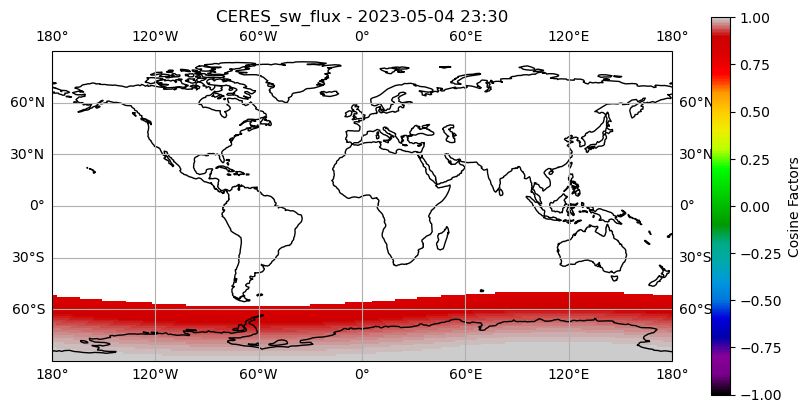

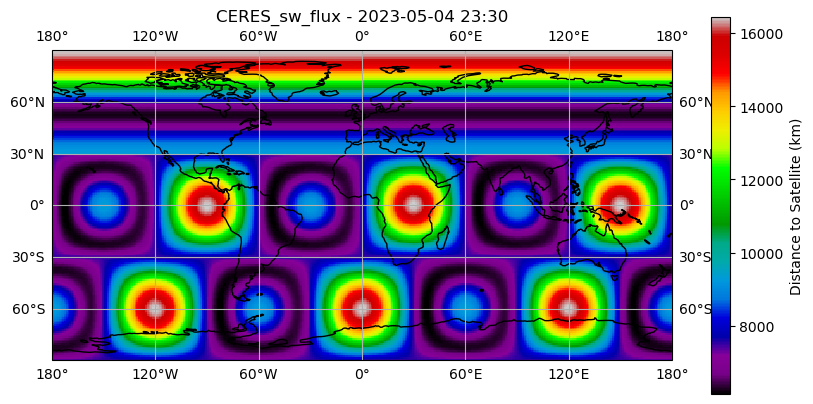

In [192]:
from itertools import islice
number_of_items = 120
for idx, (alt, sat_lat, sat_lon, ceres_idx) in islice(enumerate(zip(ow_alts, ow_lats, ow_lons, ow_ceres_indices)), number_of_items):
    print("idx:", idx)
    horizon_distance_km = calculate_satellite_fov(alt)
    plot_filename = os.path.join(output_folder, f'fov_radiance_{idx}.png')
    plot_fov_radiance("CERES_sw_flux", ceres_idx, radiation_data, lat, lon, sat_lat, sat_lon, alt, horizon_distance_km, plot_filename, ceres_times)

In [ ]:
# for idx, (alt, sat_lat, sat_lon, ceres_idx) in enumerate(zip(ow_alts, ow_lats, ow_lons, ow_ceres_indices)):
#     horizon_distance_km = calculate_satellite_fov(alt)
#     plot_filename = os.path.join(output_folder, f'fov_frame_lw_{idx}.png')
#     plot_fov_radiation_mesh("all_sky_lw_hourly", ceres_idx, radiation_data, lat, lon, sat_lat, sat_lon, horizon_distance_km, plot_filename, ceres_times)

In [145]:
# Create and save the animation
filenames = [os.path.join(output_folder, f'fov_radiance_{idx}.png') for idx in range(len(ow_alts))]
images = [imageio.imread(filename) for filename in filenames]
animation_path = os.path.join(output_folder, 'oneweb_sw_hrly_flux.gif')
imageio.mimsave(animation_path, images, duration=0.5) 

/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_78460/3789370301.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]
